In [139]:
import fiona
import json
import pandas as pd
import rasterio
from rasterio.coords import BoundingBox
from rasterio.plot import show
from pathlib import Path

import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt

In [140]:
def load_orthophoto(orthophoto_dir):
    template_path = (Path.cwd() / orthophoto_dir).resolve()
    for filepath in template_path.glob("*"):
        yield filepath, gpd.read_file(filepath)

def load_geopackage(filepath):
    geopoints = []
    with fiona.Env():
        layers = fiona.listlayers(filepath)
        for layer in layers:
            gdf = gpd.read_file(filepath, layer=layer)
            geopoints.append(gdf)
    return geopoints

In [141]:
geopackage_file = "C:\\Users\\gabri\\Documents\\Projects\\University\\reflectdetect_main\data\\20240529_uav_multispectral_orthos_20m\\20240529_tarps_locations.gpkg"

In [142]:
# Load the geopoints from the GeoPackage and save them as GeoJSON for easier access
geopoints = load_geopackage(geopackage_file)
geopoints_gdf = gpd.GeoDataFrame(pd.concat(geopoints, ignore_index=True))
geopoints_gdf.to_file('geopoints.geojson', driver='GeoJSON')

print(geopoints_gdf)

                                   UUID  FID _description   latitude  \
0  482be66a-f26f-49ff-a2b3-7a9143a105ee    1               51.564821   
1  2f9a4bcc-8c30-4f5e-bbe7-35d58a30a55a    2               51.564812   
2  668a11b3-3c57-4def-9e4e-d01c72d4e524    5               51.564797   
3  4a549ab4-a7b6-4a7c-b474-f8ec2671696e    6               51.564788   
4  7035be9a-555f-4519-ab4b-307fd06761c6    3               51.564809   
5  bbeea492-5148-484b-b208-deaa1a35ef35    4               51.564800   
6                                   NaN  NaN          NaN        NaN   

   longitude  elevation  ortho_ht                          time  fix_id  \
0   9.917781    187.380       0.0  27-05-2024 11:14:10.000 MESZ     4.0   
1   9.917758    187.400       0.0  27-05-2024 11:14:34.000 MESZ     4.0   
2   9.917774    187.397       0.0  27-05-2024 11:16:05.000 MESZ     4.0   
3   9.917750    187.375       0.0  27-05-2024 11:16:21.000 MESZ     4.0   
4   9.917777    187.366       0.0  27-05-2024 11

In [143]:
def detect(orthophoto_dir, geopoints_gdf, shape, side_length_meters=None):
    template_path = (Path.cwd() / orthophoto_dir).resolve()
    result_files = []

    if shape not in ['sq', 'rect', 'circ']:
        raise ValueError("shape must be either 'sq', 'rect', or 'circ'")
    
    # Haversine formula to calculate distance between two points in meters
    def haversine(lat1, lon1, lat2, lon2):
        R = 6378100  # Radius of the Earth in meters
        phi1 = np.radians(lat1)
        phi2 = np.radians(lat2)
        delta_phi = np.radians(lat2 - lat1)
        delta_lambda = np.radians(lon2 - lon1)
        a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        return R * c
    
    def extract_panel_location_from_image(result_files, shape, side_length_meters):
        panel_locations = []

        for filepath in result_files:
            with rasterio.open(filepath) as dataset:
                if shape == 'sq' and side_length_meters is not None:
                    pixel_size = dataset.res[0]  # Assuming square pixels
                    side_length_pixels = side_length_meters / pixel_size

                    used_points = set()

                    for i, point in geopoints_gdf.iterrows():
                        if point.geometry is not None and i not in used_points:
                            lat1, lon1 = point.geometry.y, point.geometry.x

                            for j, point2 in geopoints_gdf.iterrows():
                                if j > i and point2.geometry is not None and j not in used_points:
                                    lat2, lon2 = point2.geometry.y, point2.geometry.x

                                    # Calculate the distance between the diagonal points
                                    diagonal_distance = np.sqrt(2 * (side_length_meters ** 2))

                                    if np.isclose(haversine(lat1, lon1, lat2, lon2), diagonal_distance, atol=1.0):
                                        # Calculate the other two points
                                        dx = (lon2 - lon1) / 2
                                        dy = (lat2 - lat1) / 2

                                        # Center of the square
                                        center_lon = (lon1 + lon2) / 2
                                        center_lat = (lat1 + lat2) / 2

                                        # Calculate the other two corners
                                        point_b = Point(center_lon - dy, center_lat + dx)
                                        point_d = Point(center_lon + dy, center_lat - dx)

                                        # Convert geographic coordinates to pixel coordinates
                                        row_a, col_a = dataset.index(lon1, lat1)
                                        row_c, col_c = dataset.index(lon2, lat2)
                                        row_b, col_b = dataset.index(point_b.x, point_b.y)
                                        row_d, col_d = dataset.index(point_d.x, point_d.y)

                                        # Check if all points are within the image bounds
                                        if all(0 <= coord < dataset.width for coord in [col_a, col_b, col_c, col_d]) and all(0 <= coord < dataset.height for coord in [row_a, row_b, row_c, row_d]):
                                            panel_locations.append({
                                                "file": str(filepath),
                                                "points": [
                                                    (lon1, lat1),
                                                    (point_b.x, point_b.y),
                                                    (lon2, lat2),
                                                    (point_d.x, point_d.y)
                                                ]
                                            })
                                            used_points.update([i, j])
                                            break

        with open('panel_locations.json', 'w') as f:
            json.dump(panel_locations, f, indent=4)

    # Load each orthophoto
    for filepath in template_path.glob("*.tif"):
        with rasterio.open(filepath) as dataset:
            # Get the bounds of the orthophoto
            bounds = BoundingBox(*dataset.bounds)
            # Create a bounding box geometry
            orthophoto_box = gpd.GeoDataFrame(
                {'geometry': [Polygon(
                    [
                        (bounds.left, bounds.bottom),
                        (bounds.left, bounds.top),
                        (bounds.right, bounds.top),
                        (bounds.right, bounds.bottom)])
                    ]
                }
            )
            # Check if all points from geopoints_gdf are within the bounds
            all_points_within = True
            for _, point in geopoints_gdf.iterrows():
                if 'geometry' in point and point.geometry is not None:
                    if not orthophoto_box.contains(point.geometry).all():
                        all_points_within = False
                        break
            if all_points_within:
                result_files.append(filepath)

    extract_panel_location_from_image(result_files, shape, side_length_meters)

    return result_files

In [144]:
orthophoto_dir = "C:\\Users\\gabri\\Documents\\Projects\\University\\reflectdetect_main\data\\20240529_uav_multispectral_orthos_20m\\orthophotos"

In [145]:
side_length_meters = 1.40  
matching_files = detect(orthophoto_dir, geopoints_gdf, 'sq', side_length_meters)
#print(matching_files)

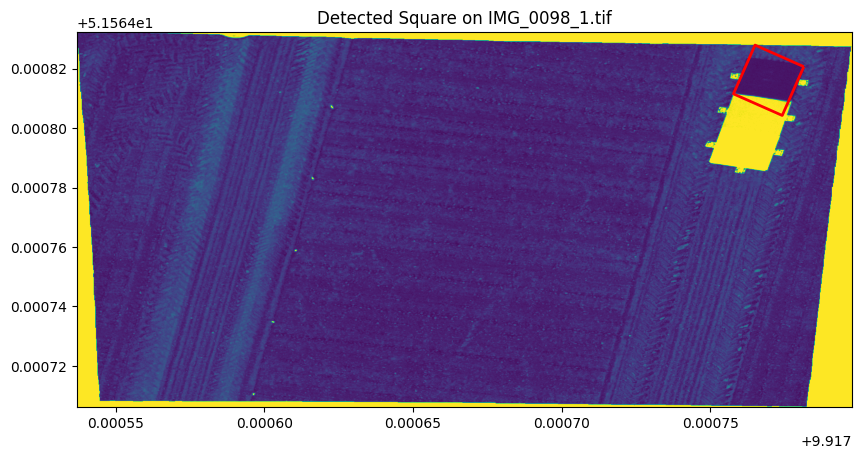

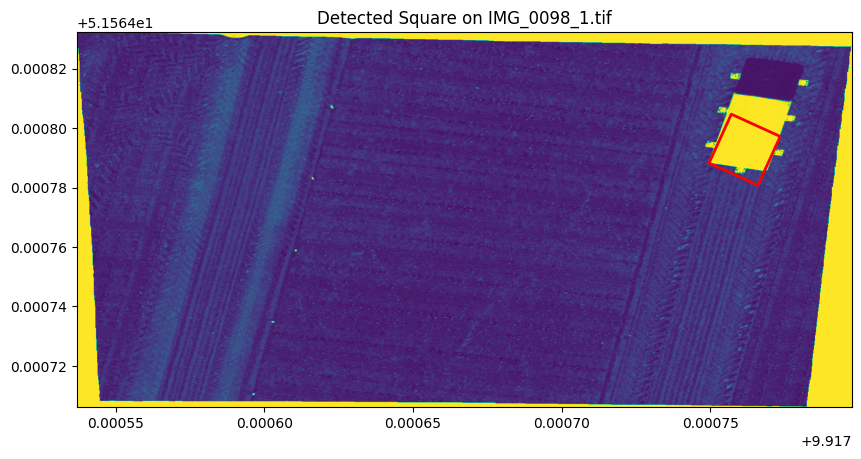

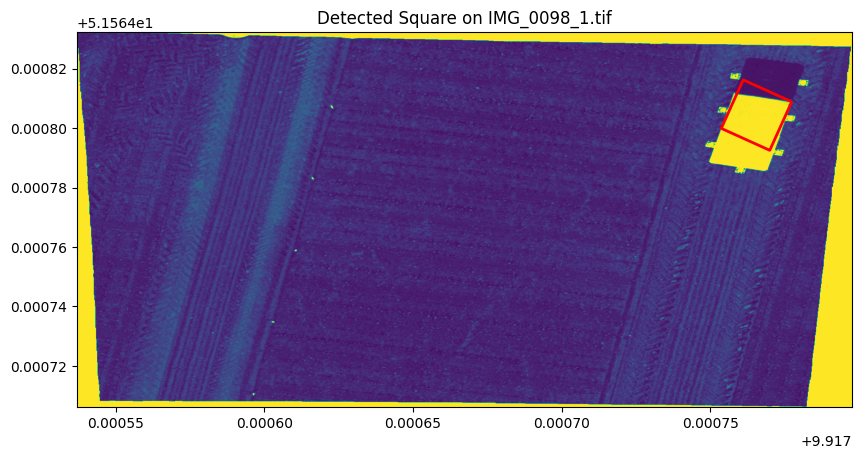

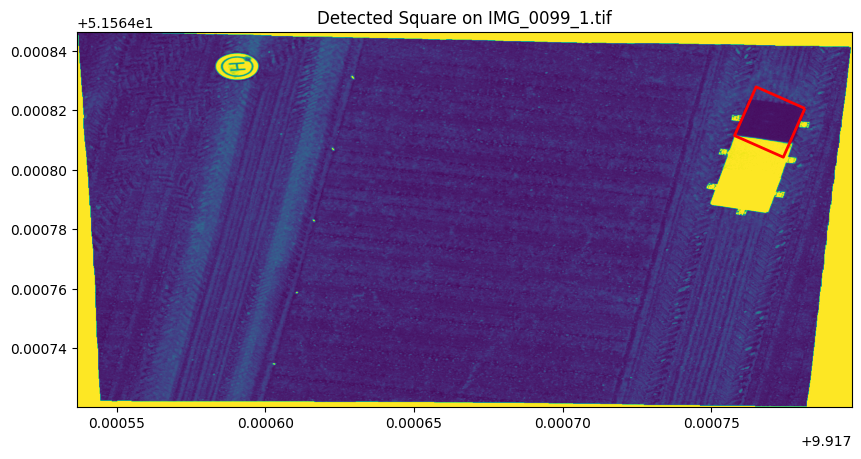

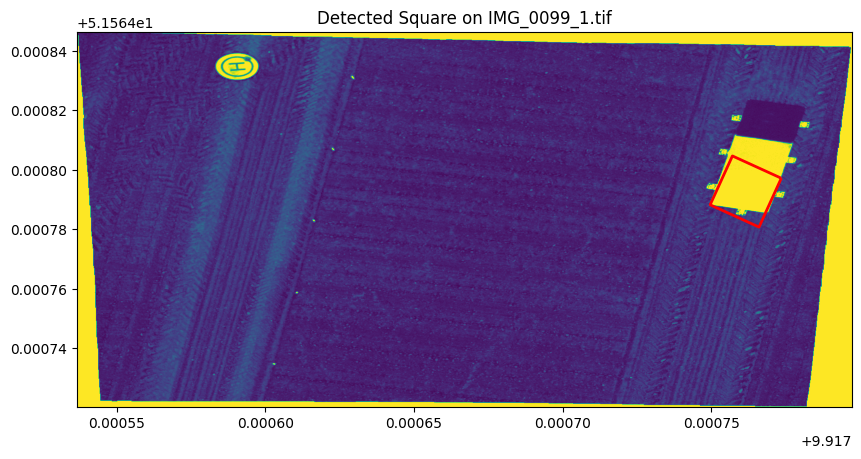

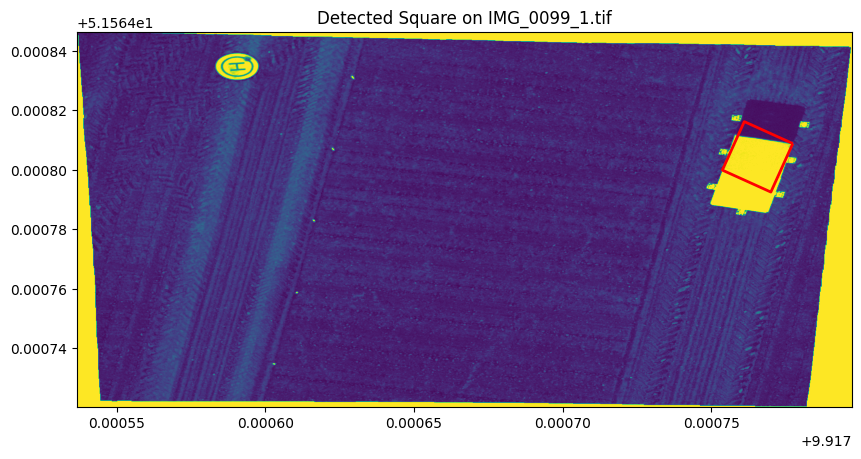

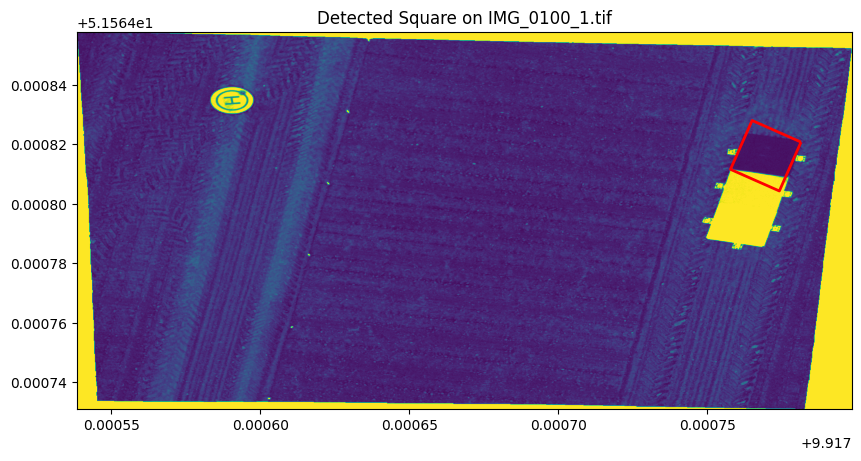

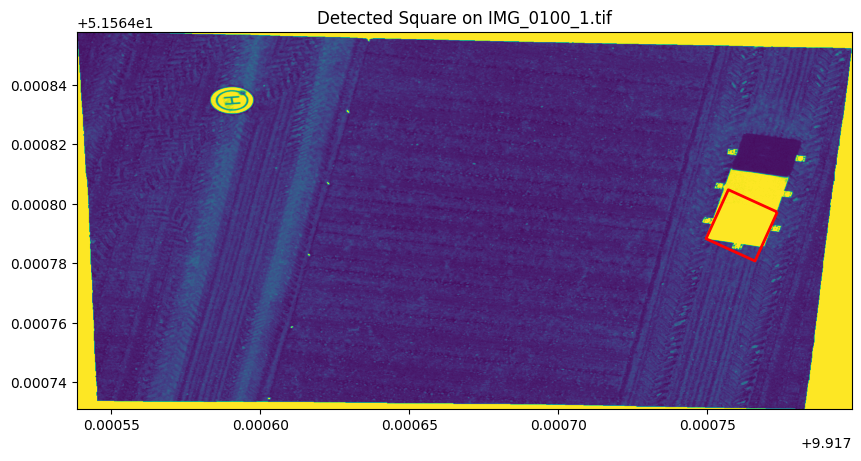

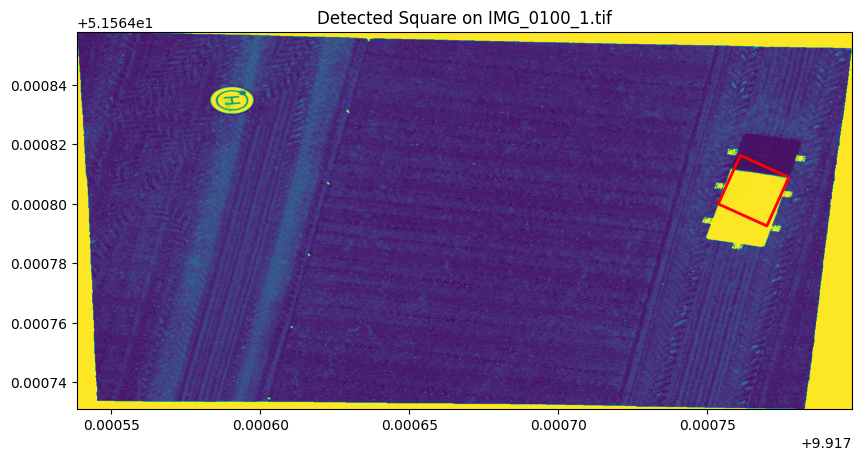

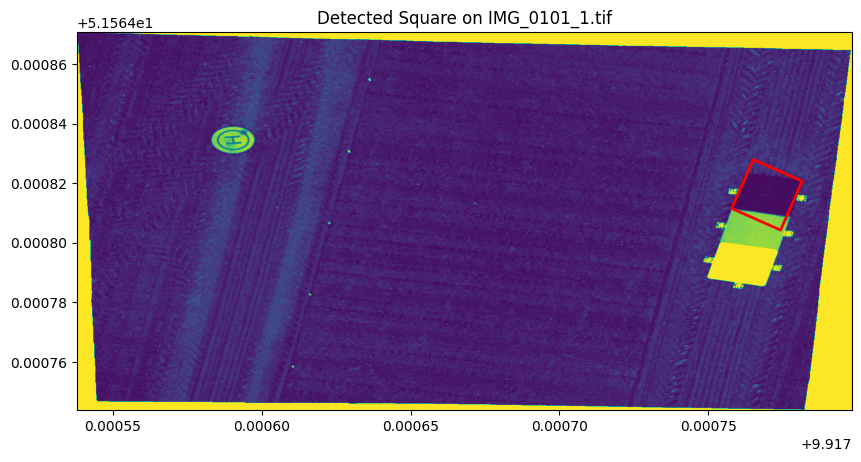

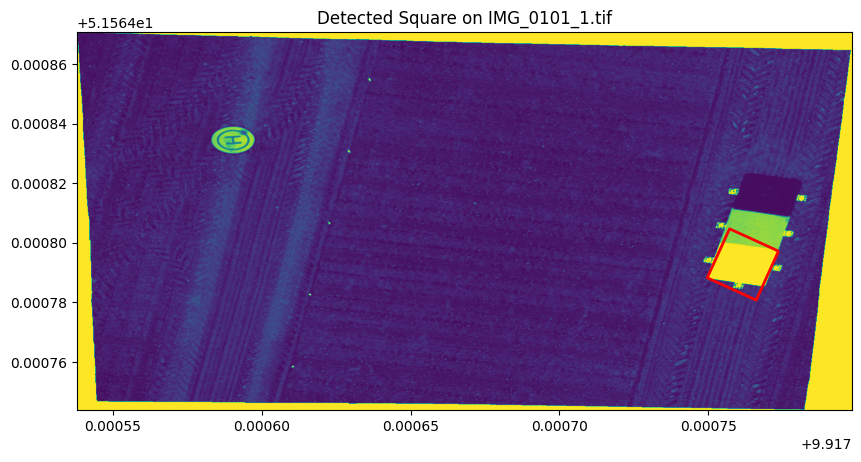

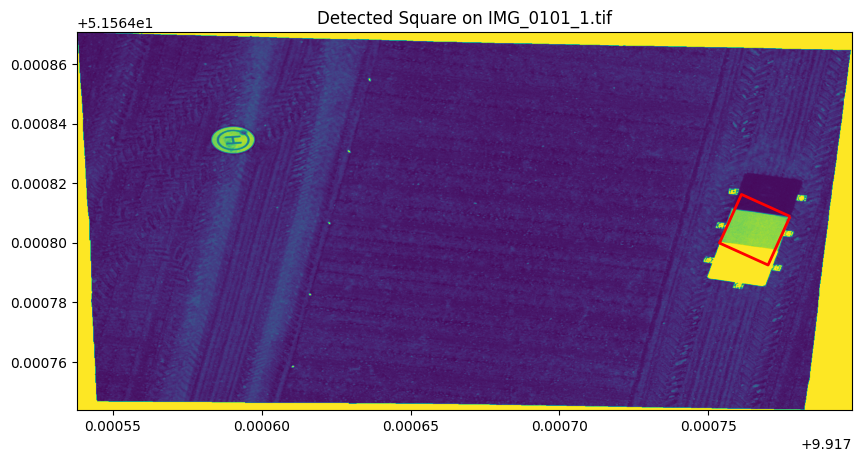

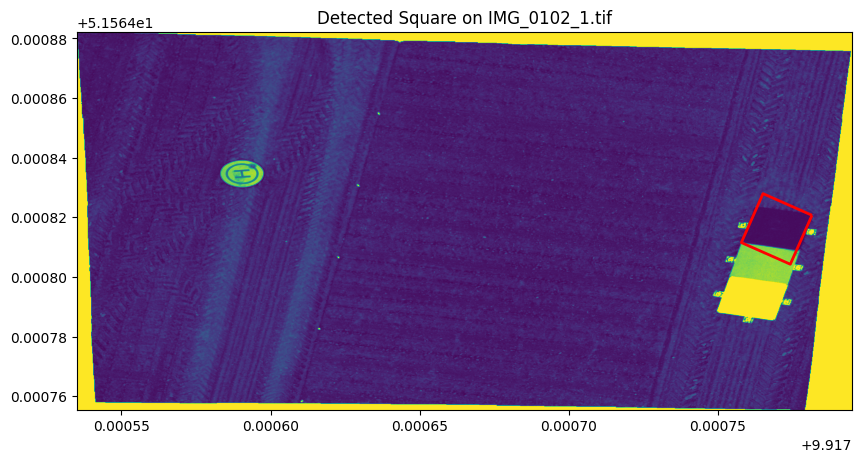

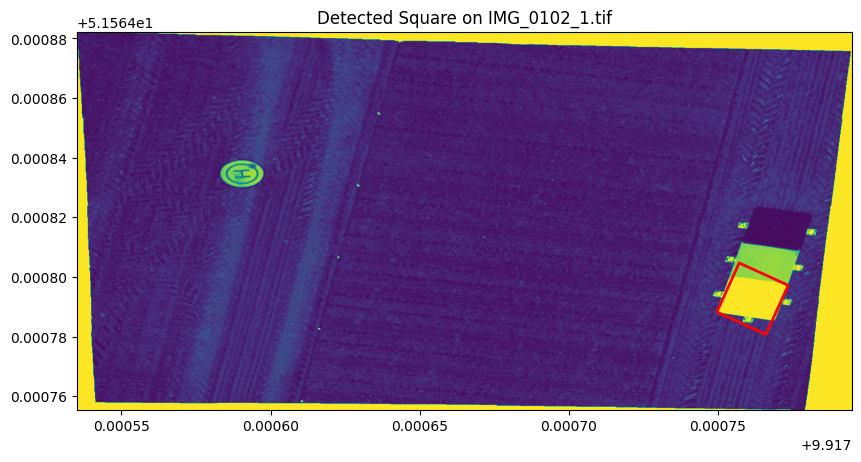

KeyboardInterrupt: 

In [146]:
import json
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import Polygon
from pathlib import Path

def plot_detected_squares(json_file):
    # Load the JSON file containing the panel locations
    with open(json_file, 'r') as f:
        panel_locations = json.load(f)

    for panel in panel_locations:
        file_path = Path(panel['file']).resolve()
        points = panel['points']
        
        # Open the orthophoto image
        with rasterio.open(file_path) as dataset:
            fig, ax = plt.subplots(figsize=(10, 10))
            show(dataset, ax=ax)
            
            # Convert the points into a list of (longitude, latitude) tuples
            square_coords = [(point[0], point[1]) for point in points]
            square_coords.append(square_coords[0])  # Close the square
            
            # Create a Polygon from the coordinates
            square = Polygon(square_coords)
            
            # Plot the square on the orthophoto
            gpd.GeoSeries([square]).plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)
            
            plt.title(f"Detected Square on {file_path.name}")
            plt.show()

plot_detected_squares('C:\\Users\\gabri\\Documents\\Projects\\University\\reflectdetect_main\\src\\panel_locations.json')
